# CIFAR-10 Image Classification with Custom Neural Network Architecture

**Author:** Rashad Malik

This notebook contains the code for my implementation of a CIFAR-10 image classification task. It is divided into 4 sections:

1.   Dataset
2.   Basic architecture
3.   Training and testing
4.   Improving the results

## 1 Dataset

In this section, we load and preprocess the CIFAR-10 dataset using PyTorch's built-in `torchvision` module. The dataset consists of 60'000 32x32 colour images across 10 different classes.

We apply standard transformations to convert images to tensors and normalise their pixel values to the range [-1, 1]. We then create DataLoader objects for both the training and test sets, enabling efficient mini-batch processing during training and evaluation.

In [1]:
# Libraries used for section 1
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Checking that we are utilising a GPU in the current environment
device = torch.device('cuda')
print(device)

cuda


Below, we define a reusable function `load_data_cifar10`, which downloads the CIFAR-10 dataset and prepares it for training and testing. It applies a series of transformations, including:
- Converting the images to tensors and normalising them to the range `[-1, 1]` per channel. The function also supports resizing the images, although this is not required for this project.
- Returns two `DataLoader` objects (`train_iter` and `test_iter`), which provide batches of data during training and evaluation. These loaders are optimised for GPU usage by enabling pinned memory and using multiple worker threads for faster data loading.

In [3]:
# Downloading the CIFAR-10 dataset and loading it into memory
def load_data_cifar10(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    trans = transforms.Compose(trans)

    cifar10_train = torchvision.datasets.CIFAR10(
        root="./data", train=True, transform=trans, download=True)
    cifar10_test = torchvision.datasets.CIFAR10(
        root="./data", train=False, transform=trans, download=True)

    return (torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
            torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True))

In [4]:
batch_size = 128 # Defines the batch size.
train_iter, test_iter = load_data_cifar10(batch_size) # Loads the CIFAR-10 dataset. `train_iter` and `test_iter` are `DataLoader` objects.

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Checking the shape of our tensor outputs from the dataset
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # 128 images per batch. Each image is represented by a 3 x 32 x 32 tensor (number of channels x height x width). The images are RGB, so there are three channels.
print(y.size()) # 128 targets. Each target is a number between 0 and 9. The classification problem has 10 classes.
print(y[:10]) # Viewing the elements within a target tensor, which should have 10 elements between 0-9.

torch.Size([128, 3, 32, 32])
torch.Size([128])
tensor([9, 5, 2, 7, 1, 1, 0, 7, 6, 1])


To check that the dataset has been loaded and transformed correctly, we can retrieve a single batch of images from the training set and display the first five images along with their corresponding class labels.

Each image tensor is converted from PyTorch's channel-first format `[C, H, W]` to the standard image format `[H, W, C]` for display. The pixel values are then unnormalised, and scaled to the `[0, 255]` range required for visualisation. Finally, the images are shown using `matplotlib`, and their class names are printed using a predefined list of CIFAR-10 labels.

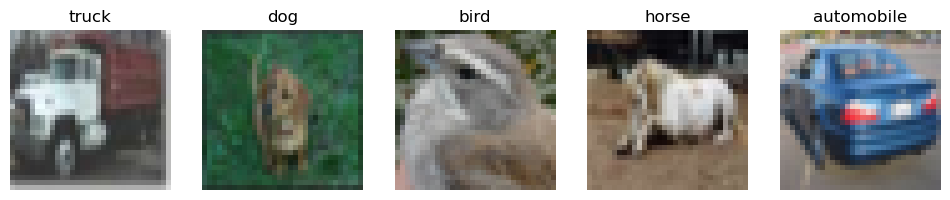

In [6]:
# CIFAR-10 class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

# Setting up the figure size
plt.figure(figsize=(12, 4))

# Looping over the first 5 images in the batch
for i in range(5):
    img = X[i].numpy().transpose(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]

    # Un-normalise the image
    img = img * 0.5 + 0.5

    # Displaying images using matplotlib
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{class_labels[int(y[i])]}")
    plt.axis('off')

plt.show()

The dataset has been successfully loaded, and we can now proceed to the next section.

## 2 Basic architecture

In this section, we implement a custom neural network architecture for CIFAR-10 classification.
- The model is composed of multiple intermediate blocks, where each block applies several parallel convolutional layers to the same input and combines their outputs using a learned set of weights.
- These weights are dynamically generated by a fully connected layer based on the channel-wise mean of the input.
- After passing through the sequence of intermediate blocks, the output is fed into a final output block, which performs global average pooling followed by fully connected layers to produce class logits for CIFAR-10 classification.

Each component is implemented as a separate PyTorch module for clarity and modularity.

In [7]:
# Libraries used for section 2
import torch
import torch.nn as nn
import torch.nn.functional as F

### 2.1 Intermediate block

This class defines an **intermediate block** used in the custom network architecture.
- Each block applies `L` independent convolutional layers in parallel to the same input tensor. The input is also globally averaged across spatial dimensions to produce a channel-wise mean vector, which is passed through a fully connected layer to generate `L × C_out` weights.
- These weights are reshaped and normalised using softmax, and then used to compute a weighted sum of the convolutional outputs.

The result is a single feature map that adaptively combines the responses of all convolutional paths based on the input, enabling dynamic feature selection within each block.

In [8]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, L=4):
        super().__init__()

        # L represents the number of independent convolutional layers
        self.L = L
        self.out_channels = out_channels

        # Defining L independent convolutional layers
        self.convs = nn.ModuleList()
        for i in range(L):
            self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))

        # Fully connected layer that takes channel-wise averages of x as input and outputs L * C_out weights
        self.fc = nn.Linear(in_channels, L * out_channels)

    def forward(self, x):
        # Batch size, channels, height, width
        B, C_in, H, W = x.shape

        # Applying each convolutional layer independently to x
        conv_outputs = []
        for i in range(self.L):
            Ci_x = self.convs[i](x)
            conv_outputs.append(Ci_x)

        # Computing the channel-wise mean of x
        m = x.mean(dim=(2, 3))

        # Computing weights from m using the fully connected layer
        a = self.fc(m)
        a = a.view(B, self.L, self.out_channels)

        # Normalising weights with softmax over the L dimension
        a = F.softmax(a, dim=1)

        # Stacking convolutional outputs and applying weights
        conv_stack = torch.stack(conv_outputs, dim=1)

        # Un-squeezing weights to match output dimensions
        a = a.unsqueeze(-1).unsqueeze(-1)

        # Weighted sum
        out = (a * conv_stack).sum(dim=1)

        return out

### 2.2 Output block

The `OutputBlock` is responsible for producing the classification output.
- It first performs global average pooling on the input feature map by computing the mean across the spatial dimensions (height and width) for each channel, resulting in a vector `m` of shape `[Batch size (B), Channels (C_in)]`.
- This vector captures a summary of the learned features. The vector is then passed through a fully connected layer with ReLU activation to introduce non-linearity, followed by a second fully connected layer that maps the hidden features to a logits vector of size 10—corresponding to the 10 CIFAR-10 classes.

This structure uses channel-wise averages to produce the final prediction.

In [9]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, hidden_dim=256):
        super().__init__()

        # Hidden fully connected layer
        self.fc1 = nn.Linear(in_channels, hidden_dim)
        self.relu = nn.ReLU()

        # Final classification layer
        self.fc2 = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        # Global average pooling over height and width = vector m
        m = x.mean(dim=(2, 3))

        # Additional hidden layer with ReLU activation, to introduce non-linearity
        h = self.relu(self.fc1(m))

        # Outputting logits for 10 classes
        logits = self.fc2(h)

        return logits

### 2.3 Full architecture

The `RashadNet` class defines the full neural network architecture used for CIFAR-10 image classification.
- It consists of a sequence of intermediate blocks, where each block applies `L` independent convolutional layers in parallel and combines their outputs using learned weights generated from the input's channel-wise mean.
- The number of blocks (`num_blocks`) and the base number of output channels (`base_channels`) can be configured to control the network's depth and width.
- After processing through all intermediate blocks, the resulting feature map is passed into the `OutputBlock`, which performs global average pooling followed by fully connected layers to produce the final 10-class logits.

The design emphasises modularity and clarity.

In [10]:
class RashadNet(nn.Module):
    def __init__(self, num_blocks=3, L=4, base_channels=32):
        super().__init__()

        # Initialising an empty list to hold the intermediate blocks
        block_list = []

        # CIFAR-10 RGB input
        in_channels = 3

        # Defining and adding each intermediate block
        for i in range(num_blocks):
            out_channels = base_channels * (2 ** i)
            block = Block(in_channels, out_channels, L)
            block_list.append(block)
            in_channels = out_channels

        # Stacking all intermediate blocks into a sequential module
        self.blocks = nn.Sequential(*block_list)

        # Final output block for classification
        self.output_block = OutputBlock(in_channels)

    def forward(self, x):
        # Passing input through all intermediate blocks
        x = self.blocks(x)

        # Passing the result through the output block
        logits = self.output_block(x)

        return logits

In [11]:
# Testing and checking the output shape for a dummy input
model = RashadNet(num_blocks=3, L=4)

dummy_input = torch.randn(8, 3, 32, 32)
print("Output shape:", model(dummy_input).shape)

Output shape: torch.Size([8, 10])


This test verifies that the `RashadNet` model produces outputs of the correct shape when given a dummy input tensor simulating a batch of CIFAR-10 images. We created a random input of shape `[8, 3, 32, 32]`, representing a batch of 8 RGB images, and pass it through the model. The output shape `[8, 10]` confirms that the network correctly processes the input and returns a logits vector of length 10 for each image, matching the number of classes in CIFAR-10. This ensures that the model is structurally sound and ready for training.

## 3 Training and testing

In this section, I train the custom neural network on the CIFAR-10 dataset. The model is trained using the cross-entropy loss function, with freedom to experiment with other hyperparameter settings.

Throughout training, both training and test accuracy are tracked and reported after each epoch. The goal is to evaluate the model's performance over time and ensure it learns to classify images correctly. This section also sets the foundation for later analysis and comparison in section 4, where further improvements will be introduced.

In [12]:
# Libraries used for section 3
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### 3.1 Accuracy function

This function, `compute_accuracy`, calculates the classification accuracy of the model by comparing predicted class labels to the true labels.
- It takes the model's output logits and determines the predicted class for each input using `argmax`, which selects the index of the highest logit value.
- It then compares these predictions to the ground truth labels, computes the proportion of correct predictions, and returns the result as a float.

In [13]:
# Accuracy function
def compute_accuracy(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

### 3.2 Main training and evaluation loop

This function handles the full training and evaluation loop for the neural network model.
- It uses the Adam optimiser (with the recommended default learning rate of 0.001 as specified by the authors of the Adam optimiser), and cross-entropy loss to train the model over a specified number of epochs.
- During each epoch, the model is trained on batches from the training set (`train_iter`), and both loss and accuracy are tracked.
- After training, the model is evaluated on the test set (`test_iter`) using `torch.no_grad()` to disable gradient computations.
- The function logs training loss, training accuracy, and test accuracy at each epoch, prints them to the console, and returns these metrics for later visualisation.

In [14]:
# Training and evaluation loop
def train_model(model, train_iter, test_iter, num_epochs=10, learning_rate=0.001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)

    # Loss and optimiser
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Logging variables
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_iter:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Tracking loss and accuracy
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
            train_losses.append(loss.item())

        train_acc = correct / total
        train_accuracies.append(train_acc)

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_iter:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)
        test_acc = correct / total
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} | Training accuracy: {train_acc:.4f} | Test accuracy: {test_acc:.4f}")

    # Return logs for plotting
    return train_losses, train_accuracies, test_accuracies

### 3.3 Plotting function

This function visualises key training metrics to help monitor model performance over time. It displays two subplots:
- The training loss recorded at each batchn
- Comparing training and test accuracy across epochs.

This visual summary provides a clear overview of how well the model is learning and generalising throughout training.

In [15]:
# Plotting function
def plot_training(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))

    # Loss per batch
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Training Loss")

    # Training and test accuracy per epoch
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy")
    plt.legend()

    plt.show()

### 3.4 Testing the model with the training and plotting function

The cell below runs a test training session using our `RashadNet` model with 3 intermediate blocks and 4 parallel convolutional layers per block.
- The model is trained for 20 epochs using the previously defined `train_model` function.
- After training, the best test accuracy achieved during the run is printed as a percentage, giving a quick summary of performance.
- Finally, the training loss and both training and test accuracies are plotted using the `plot_training` function to visualise how the model learned over time.

This step validates that the model trains correctly and provides insights into its learning behavior. Additionally, it gives us a starting benchmark before we add further improvements and enhancements in section 4.

Epoch 1/20 - Loss: 796.2382 | Training accuracy: 0.2356 | Test accuracy: 0.2643
Epoch 2/20 - Loss: 770.4613 | Training accuracy: 0.2703 | Test accuracy: 0.2899
Epoch 3/20 - Loss: 759.3736 | Training accuracy: 0.2860 | Test accuracy: 0.3113
Epoch 4/20 - Loss: 742.3297 | Training accuracy: 0.3060 | Test accuracy: 0.3180
Epoch 5/20 - Loss: 728.3378 | Training accuracy: 0.3215 | Test accuracy: 0.3258
Epoch 6/20 - Loss: 718.1654 | Training accuracy: 0.3353 | Test accuracy: 0.3466
Epoch 7/20 - Loss: 704.6519 | Training accuracy: 0.3519 | Test accuracy: 0.3588
Epoch 8/20 - Loss: 691.3199 | Training accuracy: 0.3683 | Test accuracy: 0.3729
Epoch 9/20 - Loss: 680.2092 | Training accuracy: 0.3785 | Test accuracy: 0.3788
Epoch 10/20 - Loss: 672.3048 | Training accuracy: 0.3844 | Test accuracy: 0.3874
Epoch 11/20 - Loss: 666.2301 | Training accuracy: 0.3916 | Test accuracy: 0.3930
Epoch 12/20 - Loss: 659.9940 | Training accuracy: 0.3973 | Test accuracy: 0.3889
Epoch 13/20 - Loss: 655.1748 | Traini

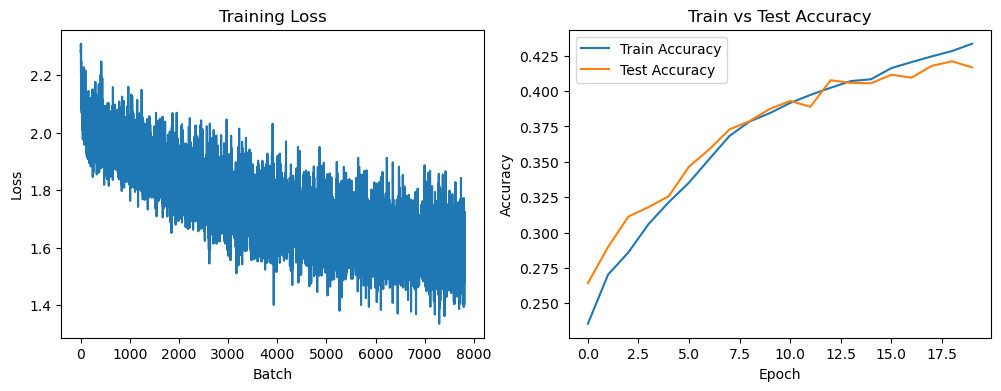

In [16]:
# Test run
model = RashadNet(num_blocks=3, L=4)
train_losses, train_accs, test_accs = train_model(model, train_iter, test_iter, num_epochs=20)
print(f"Best test accuracy: {max(test_accs)*100:.2f}%")
plot_training(train_losses, train_accs, test_accs)

In this initial baseline test run using `RashadNet` with 3 blocks and 4 convolutional paths per block, the model achieved a best test accuracy of **42.10%** after 20 epochs. The training and test accuracy curves show a steady upward trend, indicating that the model is learning and generalising to some extent. The training loss also decreases consistently across batches, which suggests effective gradient updates. However, the relatively modest final accuracy and the small gap between training and test accuracy imply that the model may be underfitting and could benefit from further improvements such as deeper architecture, data augmentation, or more training time. This run establishes a performance baseline for evaluating enhancements in later tests.

## 4 Improving the results

In this section, we explore various strategies to improve the performance of the baseline model. While I conducted a wide range of experiments involving architectural changes, regularisation techniques, and training optimisations, I have chosen to highlight two key milestones (which I grouped into waves) that resulted in the most significant improvements.

These examples demonstrate a combination of impactful ideas and diverse approaches, and serve as representative case studies of what worked best. A summary of all other experiments is provided at the end of this section for completeness.

### 4.1 First wave updates

The "first wave" of updates introduces a set of foundational changes aimed at improving the baseline model's training dynamics, generalisation, and representational power. These updates include **data augmentation** (random horizontal flips and cropping) to enrich the training data, **batch normalisation** after each convolution to stabilise learning, and **dropout** in the output block to reduce overfitting.

Additionally, the network architecture was made deeper by increasing the number of intermediate blocks, and spatial downsampling (`AvgPool2d`) was added between blocks to manage feature map size and encourage hierarchical feature learning.

Together, these enhancements provide a more robust starting point for further optimisation in subsequent tests.

#### Data augmentation

We apply data augmentation to the training images using `RandomHorizontalFlip` and `RandomCrop`. These transformations are applied before converting the images to tensors and normalising them. The goal is to artificially increase the diversity of the training data by creating slightly varied versions of each image. This helps prevent overfitting, as the model is less likely to memorize specific features of the original images and instead learns more general, robust patterns.

Notably, the test set remains untouched by augmentation to ensure evaluation is performed on unaltered data, maintaining consistency and fairness during testing.

In [17]:
# Training transform with data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Test transform remains the same (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Datasets with new transforms
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train)

test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test)

# DataLoaders
train_iter = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


#### Batch normalisation

This update enhances the `Block` class by adding a `BatchNorm2d` layer after each convolution.
- Batch normalisation helps stabilise and accelerate training by normalising the activations of each layer, reducing internal covariate shift.
- By ensuring that the inputs to each subsequent layer maintain a more consistent distribution, it allows for higher learning rates and helps prevent vanishing or exploding gradients.
- This can lead to faster convergence and improved generalisation.

In this case, each of the `L` parallel convolutional paths in the block benefits from normalisation, promoting more stable feature learning and helping the model adapt better across training iterations.

In [18]:
# Adding batch normalisation to our block class
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, L=4):
        super().__init__()

        # L represents the number of independent convolutional layers
        self.L = L
        self.out_channels = out_channels

        # Defining L independent convolutional layers followed by BatchNorm
        self.convs = nn.ModuleList()
        for i in range(self.L):
            self.convs.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels)  # BatchNorm added
            ))

        # Fully connected layer that takes channel-wise averages of x as input and outputs L * C_out weights
        self.fc = nn.Linear(in_channels, L * out_channels)

    def forward(self, x):
        # Batch size, channels, height, width
        B, C_in, H, W = x.shape

        # Applying each convolutional layer + batch norm independently to x
        conv_outputs = []
        for i in range(self.L):
            Ci_x = self.convs[i](x)
            conv_outputs.append(Ci_x)

        # Computing the channel-wise mean of x
        m = x.mean(dim=(2, 3))

        # Computing weights from m using the fully connected layer
        a = self.fc(m)
        a = a.view(B, self.L, self.out_channels)

        # Normalising weights with softmax over the L dimension
        a = F.softmax(a, dim=1)

        # Stacking convolutional outputs and applying weights
        conv_stack = torch.stack(conv_outputs, dim=1)

        # Unsqueezing weights to match output dimensions
        a = a.unsqueeze(-1).unsqueeze(-1)

        # Weighted sum
        out = (a * conv_stack).sum(dim=1)

        return out

#### Dropout

We introduce a `Dropout` layer to the output block of the network, applied after the hidden fully connected layer and its ReLU activation.
- Dropout randomly deactivates a proportion of neurons (in this case, 50%) during each training pass, which helps prevent the model from relying too heavily on specific features.
- This encourages the network to learn more robust, generalisable representations, reducing the risk of overfitting, especially when training on relatively small datasets like CIFAR-10.

The addition of dropout is particularly helpful in deeper networks and when using dense layers, where overfitting is more likely to occur.

In [19]:
# Updating the output block with dropout
class OutputBlock(nn.Module):
    def __init__(self, in_channels, hidden_dim=256, dropout_prob=0.5):
        super().__init__()

        # Hidden fully connected layer
        self.fc1 = nn.Linear(in_channels, hidden_dim)
        self.relu = nn.ReLU()

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(p=dropout_prob)

        # Final classification layer
        self.fc2 = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        # Global average pooling over height and width = vector m
        m = x.mean(dim=(2, 3))  # Shape: [B, C_in]

        # Hidden layer with ReLU activation
        h = self.relu(self.fc1(m))

        # Apply dropout
        h = self.dropout(h)

        # Output logits for 10 classes
        logits = self.fc2(h)

        return logits

#### Downsampling to deepen and optimise the network

This change updates our `RashadNet` architecture by introducing downsampling between intermediate blocks using `AvgPool2d`. After each block (except the last), the spatial dimensions of the feature maps are halved, effectively reducing the height and width by a factor of two.

This technique serves two main purposes:
  - It helps control the computational cost and memory usage as the network depth increases.
  - It encourages the network to learn increasingly abstract and high-level features in deeper layers.

In [20]:
# Updating the network with downsampling
class RashadNet(nn.Module):
    def __init__(self, num_blocks=3, L=4, base_channels=32):
        super().__init__()

        # Initialising an empty list to hold the intermediate blocks
        block_list = []

        # CIFAR-10 RGB input
        in_channels = 3

        # Defining and adding each intermediate block
        for i in range(num_blocks):
            out_channels = base_channels * (2 ** min(i, 3))  # Cap channel size at 256
            block = Block(in_channels, out_channels, L)
            block_list.append(block)

            # Add downsampling *after* block if not the last one
            if i < num_blocks - 1:
                block_list.append(nn.AvgPool2d(kernel_size=2))  # Downsample: H/2, W/2

            in_channels = out_channels  # Update for the next block

        # Stacking all intermediate blocks (and downsampling layers) into a sequential module
        self.blocks = nn.Sequential(*block_list)

        # Final output block for classification
        self.output_block = OutputBlock(in_channels)

    def forward(self, x):
        # Passing input through all intermediate blocks
        x = self.blocks(x)

        # Passing the result through the output block
        logits = self.output_block(x)

        return logits

We also increase the model's capacity by setting `num_blocks=6`, which results in a deeper network.

By deepening the architecture, the network can learn more complex and hierarchical representations of the input data. This change aims to enhance the model's expressiveness and improve its performance on more challenging visual patterns in CIFAR-10.

However, deeper models also risk overfitting, which can hopefully be mitigated with the techniques used like dropout and batch normalisation.

In [21]:
# Increasing the network blocks
model = RashadNet(num_blocks=6, L=4)

#### First wave results

Epoch 1/40 - Loss: 754.5791 | Training accuracy: 0.2912 | Test accuracy: 0.3475
Epoch 2/40 - Loss: 699.1657 | Training accuracy: 0.3521 | Test accuracy: 0.3948
Epoch 3/40 - Loss: 666.3104 | Training accuracy: 0.3877 | Test accuracy: 0.4331
Epoch 4/40 - Loss: 635.3993 | Training accuracy: 0.4181 | Test accuracy: 0.4527
Epoch 5/40 - Loss: 609.7160 | Training accuracy: 0.4404 | Test accuracy: 0.4724
Epoch 6/40 - Loss: 591.3145 | Training accuracy: 0.4610 | Test accuracy: 0.4896
Epoch 7/40 - Loss: 578.8761 | Training accuracy: 0.4722 | Test accuracy: 0.4944
Epoch 8/40 - Loss: 565.9846 | Training accuracy: 0.4859 | Test accuracy: 0.5085
Epoch 9/40 - Loss: 551.1728 | Training accuracy: 0.4977 | Test accuracy: 0.5198
Epoch 10/40 - Loss: 542.3439 | Training accuracy: 0.5073 | Test accuracy: 0.5103
Epoch 11/40 - Loss: 533.1482 | Training accuracy: 0.5147 | Test accuracy: 0.5240
Epoch 12/40 - Loss: 521.6773 | Training accuracy: 0.5270 | Test accuracy: 0.5229
Epoch 13/40 - Loss: 513.0874 | Traini

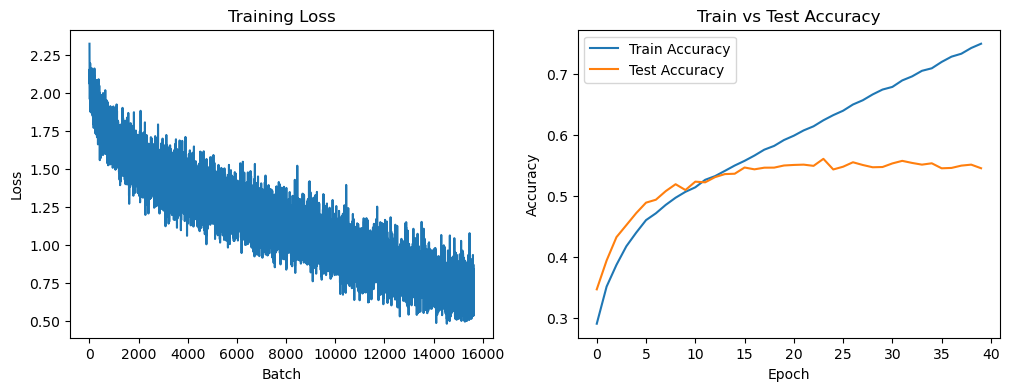

In [22]:
train_losses, train_accs, test_accs = train_model(model, train_iter, test_iter, num_epochs=40)
print(f"Best test accuracy: {max(test_accs)*100:.2f}%")
plot_training(train_losses, train_accs, test_accs)

The results of the first wave updates show a clear and meaningful improvement over the baseline model. The best test accuracy reached **56.14%**, a significant increase from the initial baseline of around 42.10%.

The training loss steadily decreased across batches, and both training and test accuracy improved consistently over the 40 epochs. However, while training accuracy continued to rise, test accuracy plateaued slightly towards the end, suggesting the onset of overfitting. This trend indicates that the model is learning effectively but may now benefit from additional regularisation or training strategies.

Overall, the combined enhancements (data augmentation, batch normalisation, dropout, downsampling, and increased depth) successfully boosted the model's learning capacity and generalisation.

### 4.2 Second wave updates

In the second wave of updates, we focused on targeted refinements to further enhance the network's performance and generalisation. Firstly, we **fine-tuned the dropout probability** within the output block, reducing it to 0.3 to strike a balance between effective regularisation and preserving valuable model capacity. Secondly, we introduced **label smoothing and a cosine annealing learning rate scheduler** to our training process. Label smoothing helps reduce overconfidence in model predictions, while the cosine annealing scheduler dynamically adjusts the learning rate, initially allowing rapid learning followed by fine-grained optimisation. Lastly, we **replaced average pooling with MaxPool**, enabling the network to better preserve salient features by focusing on the most significant activations.

Collectively, these updates boosted the model's accuracy and robustness, yielding noticeably improved generalisation to unseen data.

#### Further tuning dropout probability

In this update, the dropout probability was adjusted from 0.5 to 0.3. Lowering the dropout rate can help the model retain more learned features during training, potentially improving performance by balancing regularisation to prevent overfitting while allowing the network to capture more meaningful patterns in the data. This careful tuning aims to achieve a better generalisation performance.

In [23]:
# Updating the output block with new dropout value
class OutputBlock(nn.Module):
    def __init__(self, in_channels, hidden_dim=256, dropout_prob=0.3):
        super().__init__()

        # Hidden fully connected layer
        self.fc1 = nn.Linear(in_channels, hidden_dim)
        self.relu = nn.ReLU()

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(p=dropout_prob)

        # Final classification layer
        self.fc2 = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        # Global average pooling over height and width = vector m
        m = x.mean(dim=(2, 3))  # Shape: [B, C_in]

        # Hidden layer with ReLU activation
        h = self.relu(self.fc1(m))

        # Apply dropout
        h = self.dropout(h)

        # Output logits for 10 classes
        logits = self.fc2(h)

        return logits

#### Label smoothing and Cosine Annealing LR scheduler

In the updated training function, two key enhancements have been introduced to improve the model's performance and generalisation: label smoothing and a cosine annealing learning rate scheduler.

- Label smoothing is applied by setting `label_smoothing=0.1` in the cross-entropy loss function. This technique prevents the model from becoming overly confident in its predictions by slightly softening the target labels, which helps reduce overfitting and improves the model's ability to generalise, especially when training data may contain noisy or ambiguous labels.

- The cosine annealing learning rate scheduler gradually reduces the learning rate following a cosine curve, starting high to allow rapid learning in early epochs and tapering off to fine-tune in later epochs. This dynamic scheduling helps the model converge more effectively by avoiding sharp drops in the learning rate and can improve both stability and final accuracy. Additionally, it can help the model escape local minima during training by periodically varying the learning rate, thus potentially achieving better generalisation performance.

Together, these changes make the training process more robust and adaptive, often resulting in better overall performance.

In [24]:
# Updating the training function with label smoothing and the cosine annealing LR scheduler
def train_model(model, train_iter, test_iter, num_epochs=10, learning_rate=0.001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)

    # Loss function with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Optimiser
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Cosine Annealing learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

    # Logging variables
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_iter:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
            train_losses.append(loss.item())

        train_acc = correct / total
        train_accuracies.append(train_acc)

        # Step the LR scheduler
        scheduler.step()

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_iter:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)
        test_acc = correct / total
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} | Training accuracy: {train_acc:.4f} | Test accuracy: {test_acc:.4f}")

    return train_losses, train_accuracies, test_accuracies

#### MaxPool

In the below update to the `RashadNet` architecture, the key change is the replacement of average pooling with **max pooling** for spatial downsampling, applied only after the first five intermediate blocks. This adjustment helps control the spatial dimensions of the feature maps, preventing them from shrinking to invalid sizes during deep forward passes, especially in deeper networks.

Max pooling is particularly effective in highlighting the most salient features in an image, as it retains only the highest activations within local regions. This makes the network more robust to small translations and distortions in the input images, and helps focus on the most informative parts of the image for classification. Limiting pooling to the first few blocks also preserves enough spatial resolution in later layers, which is important for fine-grained feature extraction.

In [25]:
# Updating the network with max pooling
class RashadNet(nn.Module):
    def __init__(self, num_blocks=3, L=4, base_channels=32):
        super().__init__()

        # Initialising an empty list to hold the intermediate blocks
        block_list = []

        # CIFAR-10 RGB input
        in_channels = 3

        # Defining and adding each intermediate block
        for i in range(num_blocks):
            out_channels = base_channels * (2 ** min(i, 3))  # Cap channel size at 256
            block = Block(in_channels, out_channels, L)
            block_list.append(block)

            # Pool only on first 5 blocks
            if i < 5:
                # Changed to MaxPool2d
                block_list.append(nn.MaxPool2d(kernel_size=2))

            in_channels = out_channels

        # Stacking all intermediate blocks (and downsampling layers) into a sequential module
        self.blocks = nn.Sequential(*block_list)

        # Final output block for classification
        self.output_block = OutputBlock(in_channels)

    def forward(self, x):
        # Passing input through all intermediate blocks
        x = self.blocks(x)

        # Passing the result through the output block
        logits = self.output_block(x)

        return logits

We have increased the number of intermediate blocks from 6 to 10, deepening the network, allowing it to learn more complex and hierarchical features from the input images. Additionally, we increased the `base_channels` parameter from 32 to 64, effectively widening the network by providing each convolutional layer with more feature maps. This combination of increased depth and width helps the network capture richer, more detailed representations, improving the overall classification accuracy.

In [26]:
# Further increasing the network blocks (from 6 to 10) and base channels from 32 to 64
model = RashadNet(num_blocks=10, L=4, base_channels=64)

#### Second wave results

Epoch 1/40 - Loss: 675.2219 | Training accuracy: 0.4208 | Test accuracy: 0.5303
Epoch 2/40 - Loss: 557.3429 | Training accuracy: 0.5864 | Test accuracy: 0.6404
Epoch 3/40 - Loss: 503.2689 | Training accuracy: 0.6502 | Test accuracy: 0.6826
Epoch 4/40 - Loss: 471.1875 | Training accuracy: 0.6918 | Test accuracy: 0.6627
Epoch 5/40 - Loss: 446.2939 | Training accuracy: 0.7218 | Test accuracy: 0.7265
Epoch 6/40 - Loss: 425.8395 | Training accuracy: 0.7478 | Test accuracy: 0.7444
Epoch 7/40 - Loss: 411.5328 | Training accuracy: 0.7630 | Test accuracy: 0.7646
Epoch 8/40 - Loss: 395.5109 | Training accuracy: 0.7817 | Test accuracy: 0.7689
Epoch 9/40 - Loss: 384.6158 | Training accuracy: 0.7984 | Test accuracy: 0.7932
Epoch 10/40 - Loss: 372.4356 | Training accuracy: 0.8092 | Test accuracy: 0.7890
Epoch 11/40 - Loss: 362.0540 | Training accuracy: 0.8225 | Test accuracy: 0.8028
Epoch 12/40 - Loss: 353.4043 | Training accuracy: 0.8312 | Test accuracy: 0.8088
Epoch 13/40 - Loss: 344.4180 | Traini

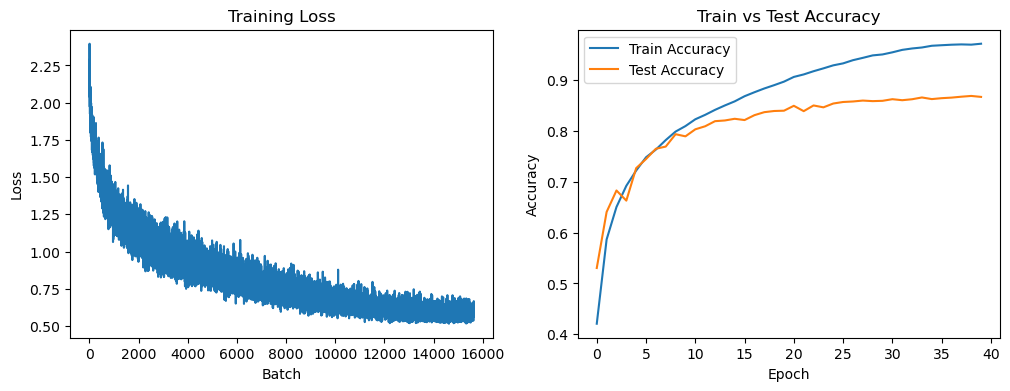

In [27]:
train_losses, train_accs, test_accs = train_model(model, train_iter, test_iter, num_epochs=40)
print(f"Best test accuracy: {max(test_accs)*100:.2f}%")
plot_training(train_losses, train_accs, test_accs)

The results from the second wave of updates show significant improvements in both training and test accuracy. The model achieved a best test accuracy of **86.84%**, which is an improvement over the first wave's results (56.14%). The plots indicate a healthy convergence, with training loss consistently decreasing and training accuracy progressively improving, eventually reaching near-perfect values above 97%. There is a large gap between training and test accuracy, suggesting some degree of overfitting. Despite this, the gap is not excessively large, and the model still generalises well to unseen data.

Further fine-tuning, such as adjusting regularisation techniques or slightly increasing dropout, could potentially narrow this gap and enhance performance even further.

### 4.3 Summary of updates (including additional test results)

Below is a table summary of the key tests, showing the key changes done to our model, and how it affected the best test accuracy.

| **Test** | **Description**                                                | **Key Parameter Changes**                                     | **Best Test Accuracy** |
|----------------|----------------------------------------------------------------|---------------------------------------------------------------|------------------------|
| Baseline | Initial model | `num_blocks=3`, `base_channels=32`, `epochs=20` | 42.10%  |
| 1 | First wave updates | Data augmentation, batch normalisation, dropout (`0.5`), deeper network (`num_blocks=6`) with downsampling (`AvgPool2d`), `epochs=40` | 56.14% |
| 2 | Second wave updates | Label smoothing (`0.1`), cosine annealing LR, dropout update (`0.3`), `MaxPool2d`, deeper network (`num_blocks=8`), wider network (`base_channels=64`), `epochs=40` | 86.84% |

There were additional tests done with further optimisation techniques, however, they were not able to surpass the score achieved with the second wave updates. The scores are documented below for reference:

| Test | Description | Best Test Accuracy |
|------------|-------------|--------------------|
| 3 | Random erasing ("Cutout") augmentation | 84.74% |
| 4 | MixUp augmentation with label smoothing (`0.1`) | 84.70% |
| 5 | MixUp augmentation without label smoothing | 85.03% |